In [19]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable, Tuple, Dict, List, Optional, Union
from mpl_toolkits.mplot3d import Axes3D


class CountedFunc:
    """Класс для подсчета вычислений целевой функции"""

    def __init__(self, func: Callable):
        self.func = func
        self.evals = 0

    def __call__(self, x: Union[float, np.ndarray]) -> float:
        self.evals += 1
        return self.func(x)

    def reset(self):
        self.evals = 0


# Функция Гаусса: f(x) = x₁² + (4x₁ + x₂)² + 18x₂² → min
def f_gauss(x: np.ndarray) -> float:
    """f(x) = x₁² + (4x₁ + x₂)² + 18x₂² → min"""
    x1, x2 = x
    return x1**2 + (4 * x1 + x2) ** 2 + 18 * x2**2


# Квадратичная функция: f(x) = 2x₁² - 2x₁ + x₁x₂ - x₂ + x₂²
def f_quadratic(x: np.ndarray) -> float:
    """f(x) = 2x₁² - 2x₁ + x₁x₂ - x₂ + x₂²"""
    x1, x2 = x
    return 2 * x1**2 - 2 * x1 + x1 * x2 - x2 + x2**2


def golden_section_search(
    f: Callable, a: float, b: float, tol: float = 1e-9, maxiter: int = 2000
) -> Tuple[float, float]:
    """
    Метод золотого сечения для нахождения точного минимума (эталон)
    Только для одномерных функций
    """
    gr = (math.sqrt(5) - 1) / 2  # золотое сечение
    c = b - gr * (b - a)
    d = a + gr * (b - a)
    fc = f(c)
    fd = f(d)

    for _ in range(maxiter):
        if abs(b - a) < tol:
            break

        if fc < fd:
            b = d
            d = c
            fd = fc
            c = b - gr * (b - a)
            fc = f(c)
        else:
            a = c
            c = d
            fc = fd
            d = a + gr * (b - a)
            fd = f(d)

    x_min = (a + b) / 2
    return x_min, f(x_min)


def gradient_descent_optimal(
    f: Callable, x0: np.ndarray, eps: float = 1e-6, max_iter: int = 1000
) -> Tuple[np.ndarray, float, int, int]:
    """
    Метод наискорейшего градиентного спуска с оптимальным шагом
    """

    def numerical_gradient(x, h=1e-6):
        grad = np.zeros_like(x)
        for i in range(len(x)):
            x_plus = x.copy()
            x_minus = x.copy()
            x_plus[i] += h
            x_minus[i] -= h
            grad[i] = (f(x_plus) - f(x_minus)) / (2 * h)
        return grad

    def line_search(x, d):
        """Поиск оптимального шага вдоль направления методом золотого сечения"""

        def phi(alpha):
            return f(x + alpha * d)

        alpha_opt, _ = golden_section_search(phi, 0, 1.0, tol=eps / 10)
        return alpha_opt

    x_current = x0.copy()
    iterations = 0
    evaluations = 0

    for k in range(max_iter):
        # Вычисление градиента
        grad = numerical_gradient(x_current)
        evaluations += 1

        # Проверка условия остановки
        if np.linalg.norm(grad) < eps:
            break

        # Направление спуска (антиградиент)
        direction = -grad

        # Поиск оптимального шага
        alpha = line_search(x_current, direction)

        # Обновление точки
        x_new = x_current + alpha * direction

        iterations += 1

        # Дополнительная проверка сходимости
        if np.linalg.norm(x_new - x_current) < eps:
            break

        x_current = x_new

    return x_current, f(x_current), iterations, evaluations


def fletcher_reeves_method(
    f: Callable, x0: np.ndarray, eps: float = 1e-6, max_iter: int = 1000
) -> Tuple[np.ndarray, float, int, int]:
    """
    Метод Флетчера-Ривса (сопряженных градиентов)
    """

    def numerical_gradient(x, h=1e-6):
        grad = np.zeros_like(x)
        for i in range(len(x)):
            x_plus = x.copy()
            x_minus = x.copy()
            x_plus[i] += h
            x_minus[i] -= h
            grad[i] = (f(x_plus) - f(x_minus)) / (2 * h)
        return grad

    def line_search(x, d, alpha_max=1.0):
        """Поиск вдоль направления методом золотого сечения"""

        def phi(alpha):
            return f(x + alpha * d)

        alpha_opt, _ = golden_section_search(phi, 0, alpha_max, tol=eps / 10)
        return alpha_opt

    x_current = x0.copy()
    g_current = numerical_gradient(x_current)
    d_current = -g_current  # начальное направление - антиградиент

    iterations = 0
    evaluations = 1  # уже вычислили градиент

    for k in range(max_iter):
        # Поиск оптимального шага вдоль направления
        alpha = line_search(x_current, d_current)

        # Обновление точки
        x_new = x_current + alpha * d_current
        g_new = numerical_gradient(x_new)
        evaluations += 1

        # Вычисление коэффициента Флетчера-Ривса
        beta = np.dot(g_new, g_new) / np.dot(g_current, g_current)

        # Новое сопряженное направление
        d_new = -g_new + beta * d_current

        # Проверка условия остановки
        if np.linalg.norm(g_new) < eps:
            break

        # Обновление переменных для следующей итерации
        x_current = x_new
        g_current = g_new
        d_current = d_new
        iterations += 1

    return x_current, f(x_current), iterations, evaluations


def gauss_seidel_method(
    f: Callable,
    x0: np.ndarray,
    bounds: List[Tuple[float, float]],
    eps: float = 1e-5,
    max_iter: int = 1000,
) -> Tuple[np.ndarray, float, int, int]:
    """
    Метод Гаусса-Зейделя (метод покоординатного спуска)
    """
    dim = len(x0)
    x_current = x0.copy()
    f_current = f(x_current)

    iterations = 0
    evaluations = 0

    for k in range(max_iter):
        x_old = x_current.copy()

        # Минимизация по каждой координате
        for i in range(dim):
            # Функция для минимизации по i-й координате
            def f_i(x_i):
                x_temp = x_current.copy()
                x_temp[i] = x_i
                return f(x_temp)

            # Используем золотое сечение для минимизации по одной координате
            cf = CountedFunc(f_i)
            x_opt, f_opt = golden_section_search(
                cf, bounds[i][0], bounds[i][1], tol=eps / 10
            )
            evaluations += cf.evals

            x_current[i] = x_opt
            f_current = f_opt

        iterations += 1

        # Проверка условия остановки
        if np.linalg.norm(x_current - x_old) < eps:
            break

    return x_current, f_current, iterations, evaluations


class OptimizationExperiment:
    """Класс для проведения экспериментов оптимизации"""

    def __init__(self):
        self.bounds_2d = [(-3.0, 3.0), (-3.0, 3.0)]  # для 2D функций
        self.results = []

    def compute_reference_minima(self):
        """Вычисление эталонных минимумов с высокой точностью"""
        print("Вычисление эталонных минимумов...")

        # Для функции Гаусса - аналитическое решение
        self.ref_x_gauss = np.array([0.0, 0.0])
        self.ref_val_gauss = f_gauss(self.ref_x_gauss)

        # Для квадратичной функции - аналитическое решение
        # f(x) = 2x₁² - 2x₁ + x₁x₂ - x₂ + x₂²
        # Система уравнений:
        # ∂f/∂x₁ = 4x₁ - 2 + x₂ = 0
        # ∂f/∂x₂ = x₁ - 1 + 2x₂ = 0
        # Решение: x₁ = 3/7, x₂ = 2/7
        self.ref_x_quadratic = np.array([3 / 7, 2 / 7])
        self.ref_val_quadratic = f_quadratic(self.ref_x_quadratic)

        print(
            f"Функция f_gauss: x_min = [{self.ref_x_gauss[0]:.8f}, {self.ref_x_gauss[1]:.8f}], f_min = {self.ref_val_gauss:.8f}"
        )
        print(
            f"Функция f_quadratic: x_min = [{self.ref_x_quadratic[0]:.8f}, {self.ref_x_quadratic[1]:.8f}], f_min = {self.ref_val_quadratic:.8f}"
        )

        return {
            "f_gauss": {"x_min": self.ref_x_gauss, "f_min": self.ref_val_gauss},
            "f_quadratic": {
                "x_min": self.ref_x_quadratic,
                "f_min": self.ref_val_quadratic,
            },
        }

    def run_gradient_descent_experiments(
        self, eps_values: List[float], initial_points: List[np.ndarray]
    ):
        """Эксперименты с методом наискорейшего градиентного спуска"""
        print("\nЗапуск экспериментов методом наискорейшего градиентного спуска...")

        for eps in eps_values:
            for x0 in initial_points:
                for func_name, func, ref_val in [
                    ("f_gauss", f_gauss, self.ref_val_gauss),
                    ("f_quadratic", f_quadratic, self.ref_val_quadratic),
                ]:
                    cf = CountedFunc(func)
                    x_min, f_min, iterations, evaluations = gradient_descent_optimal(
                        cf, x0, eps=eps
                    )

                    self.results.append(
                        {
                            "function": func_name,
                            "method": "gradient_descent",
                            "dimension": 2,
                            "parameter": eps,
                            "parameter_name": "epsilon",
                            "initial_point": str(x0),
                            "x_min": x_min,
                            "f_min": f_min,
                            "error": abs(f_min - ref_val),
                            "evaluations": evaluations,
                            "iterations": iterations,
                        }
                    )

    def run_fletcher_reeves_experiments(
        self, eps_values: List[float], initial_points: List[np.ndarray]
    ):
        """Эксперименты с методом Флетчера-Ривса"""
        print("\nЗапуск экспериментов методом Флетчера-Ривса...")

        for eps in eps_values:
            for x0 in initial_points:
                for func_name, func, ref_val in [
                    ("f_gauss", f_gauss, self.ref_val_gauss),
                    ("f_quadratic", f_quadratic, self.ref_val_quadratic),
                ]:
                    cf = CountedFunc(func)
                    x_min, f_min, iterations, evaluations = fletcher_reeves_method(
                        cf, x0, eps=eps
                    )

                    self.results.append(
                        {
                            "function": func_name,
                            "method": "fletcher_reeves",
                            "dimension": 2,
                            "parameter": eps,
                            "parameter_name": "epsilon",
                            "initial_point": str(x0),
                            "x_min": x_min,
                            "f_min": f_min,
                            "error": abs(f_min - ref_val),
                            "evaluations": evaluations,
                            "iterations": iterations,
                        }
                    )

    def run_gauss_seidel_experiments(
        self, eps_values: List[float], initial_points: List[np.ndarray]
    ):
        """Эксперименты с методом Гаусса-Зейделя"""
        print("\nЗапуск экспериментов методом Гаусса-Зейделя...")

        for eps in eps_values:
            for x0 in initial_points:
                for func_name, func, ref_val in [
                    ("f_gauss", f_gauss, self.ref_val_gauss),
                    ("f_quadratic", f_quadratic, self.ref_val_quadratic),
                ]:
                    cf = CountedFunc(func)
                    x_min, f_min, iterations, evaluations = gauss_seidel_method(
                        cf, x0, self.bounds_2d, eps=eps
                    )

                    self.results.append(
                        {
                            "function": func_name,
                            "method": "gauss_seidel",
                            "dimension": 2,
                            "parameter": eps,
                            "parameter_name": "epsilon",
                            "initial_point": str(x0),
                            "x_min": x_min,
                            "f_min": f_min,
                            "error": abs(f_min - ref_val),
                            "evaluations": evaluations,
                            "iterations": iterations,
                        }
                    )

    def create_results_dataframe(self) -> pd.DataFrame:
        """Создание DataFrame с результатами"""
        df = pd.DataFrame(self.results)

        # Переупорядочивание столбцов для лучшей читаемости
        columns_order = [
            "function",
            "method",
            "dimension",
            "parameter",
            "parameter_name",
            "initial_point",
            "x_min",
            "f_min",
            "error",
            "evaluations",
            "iterations",
        ]

        # Добавляем отсутствующие столбцы
        for col in columns_order:
            if col not in df.columns:
                df[col] = np.nan

        return df[columns_order]

    def plot_function_analysis(self):
        """Анализ функций"""
        print("\nАнализ функций:")
        print("1. f(x) = x₁² + (4x₁ + x₂)² + 18x₂²")
        print("   Минимум: x* = (0, 0), f(x*) = 0")
        print("   Матрица Гессе: [[34, 8], [8, 38]]")
        print("   Собственные значения: ~39.66, ~32.34")
        print("   Сильно выпуклая квадратичная функция")

        print("\n2. f(x) = 2x₁² - 2x₁ + x₁x₂ - x₂ + x₂²")
        print("   Минимум: x* = (3/7, 2/7), f(x*) = -5/7 ≈ -0.7143")
        print("   Матрица Гессе: [[4, 1], [1, 2]]")
        print("   Собственные значения: ~4.41, ~1.59")
        print("   Выпуклая квадратичная функция")

        # Визуализация функций
        x1 = np.linspace(-2, 2, 100)
        x2 = np.linspace(-2, 2, 100)
        X1, X2 = np.meshgrid(x1, x2)

        fig = plt.figure(figsize=(15, 10))

        # Функция Гаусса
        Z_gauss = np.array(
            [[f_gauss(np.array([x1_val, x2_val])) for x1_val in x1] for x2_val in x2]
        )

        ax1 = fig.add_subplot(2, 3, 1, projection="3d")
        ax1.plot_surface(X1, X2, Z_gauss, cmap="viridis", alpha=0.8)
        ax1.scatter(
            *self.ref_x_gauss, self.ref_val_gauss, color="red", s=100, label="Минимум"
        )
        ax1.set_title("f(x) = x₁² + (4x₁ + x₂)² + 18x₂²")
        ax1.set_xlabel("x₁")
        ax1.set_ylabel("x₂")

        ax2 = fig.add_subplot(2, 3, 2)
        contour = ax2.contour(X1, X2, Z_gauss, levels=20)
        ax2.clabel(contour, inline=True, fontsize=8)
        ax2.scatter(*self.ref_x_gauss, color="red", s=100, label="Минимум")
        ax2.set_title("Контур функции Гаусса")
        ax2.set_xlabel("x₁")
        ax2.set_ylabel("x₂")

        # Квадратичная функция
        Z_quad = np.array(
            [
                [f_quadratic(np.array([x1_val, x2_val])) for x1_val in x1]
                for x2_val in x2
            ]
        )

        ax3 = fig.add_subplot(2, 3, 3, projection="3d")
        ax3.plot_surface(X1, X2, Z_quad, cmap="plasma", alpha=0.8)
        ax3.scatter(
            *self.ref_x_quadratic,
            self.ref_val_quadratic,
            color="red",
            s=100,
            label="Минимум",
        )
        ax3.set_title("f(x) = 2x₁² - 2x₁ + x₁x₂ - x₂ + x₂²")
        ax3.set_xlabel("x₁")
        ax3.set_ylabel("x₂")

        ax4 = fig.add_subplot(2, 3, 4)
        contour = ax4.contour(X1, X2, Z_quad, levels=20)
        ax4.clabel(contour, inline=True, fontsize=8)
        ax4.scatter(*self.ref_x_quadratic, color="red", s=100, label="Минимум")
        ax4.set_title("Контур квадратичной функции")
        ax4.set_xlabel("x₁")
        ax4.set_ylabel("x₂")

        # Сравнение рельефа функций
        ax5 = fig.add_subplot(2, 3, 5)
        im1 = ax5.contourf(X1, X2, Z_gauss, levels=50, cmap="viridis")
        plt.colorbar(im1, ax=ax5)
        ax5.scatter(*self.ref_x_gauss, color="white", s=100)
        ax5.set_title("Тепловая карта функции Гаусса")
        ax5.set_xlabel("x₁")
        ax5.set_ylabel("x₂")

        ax6 = fig.add_subplot(2, 3, 6)
        im2 = ax6.contourf(X1, X2, Z_quad, levels=50, cmap="plasma")
        plt.colorbar(im2, ax=ax6)
        ax6.scatter(*self.ref_x_quadratic, color="white", s=100)
        ax6.set_title("Тепловая карта квадратичной функции")
        ax6.set_xlabel("x₁")
        ax6.set_ylabel("x₂")

        plt.tight_layout()
        plt.show()

    def plot_comparison_all_methods(self, df: pd.DataFrame):
        """Сравнение всех методов для обеих функций"""
        functions = ["f_gauss", "f_quadratic"]
        colors = {
            "gradient_descent": "blue",
            "fletcher_reeves": "red",
            "gauss_seidel": "green",
        }
        markers = {"gradient_descent": "o", "fletcher_reeves": "s", "gauss_seidel": "^"}

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        for i, func_name in enumerate(functions):
            func_data = df[df["function"] == func_name]

            # Точность vs вычисления
            ax1 = axes[i, 0]
            for method in colors.keys():
                method_data = func_data[func_data["method"] == method]
                if not method_data.empty:
                    ax1.loglog(
                        method_data["evaluations"],
                        method_data["error"],
                        marker=markers[method],
                        color=colors[method],
                        linewidth=2,
                        markersize=6,
                        label=method,
                        alpha=0.7,
                    )

            ax1.set_xlabel("Количество вычислений функции")
            ax1.set_ylabel("Погрешность")
            ax1.set_title(f"{func_name}: Точность vs Вычисления")
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # Точность vs итерации
            ax2 = axes[i, 1]
            for method in colors.keys():
                method_data = func_data[func_data["method"] == method]
                if not method_data.empty:
                    ax2.semilogy(
                        method_data["iterations"],
                        method_data["error"],
                        marker=markers[method],
                        color=colors[method],
                        linewidth=2,
                        markersize=6,
                        label=method,
                        alpha=0.7,
                    )

            ax2.set_xlabel("Количество итераций")
            ax2.set_ylabel("Погрешность")
            ax2.set_title(f"{func_name}: Точность vs Итерации")
            ax2.legend()
            ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_detailed_analysis(self, df: pd.DataFrame):
        """Детальный анализ методов"""
        functions = ["f_gauss", "f_quadratic"]

        for func_name in functions:
            func_data = df[df["function"] == func_name]

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
            fig.suptitle(f"Детальный анализ методов для {func_name}", fontsize=16)

            # Сравнение всех методов
            methods = func_data["method"].unique()
            colors = {
                "gradient_descent": "blue",
                "fletcher_reeves": "red",
                "gauss_seidel": "green",
            }

            for method in methods:
                method_data = func_data[func_data["method"] == method]
                if not method_data.empty:
                    ax1.loglog(
                        method_data["evaluations"],
                        method_data["error"],
                        "o-",
                        color=colors.get(method, "black"),
                        linewidth=2,
                        markersize=6,
                        label=method,
                    )

            ax1.set_xlabel("Вычисления функции")
            ax1.set_ylabel("Погрешность")
            ax1.set_title("Сравнение всех методов")
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # Влияние точности на сходимость
            for method in methods:
                method_data = func_data[func_data["method"] == method]
                if not method_data.empty:
                    ax2.semilogy(
                        method_data["parameter"],
                        method_data["error"],
                        "o-",
                        color=colors.get(method, "black"),
                        linewidth=2,
                        markersize=6,
                        label=method,
                    )

            ax2.set_xlabel("Точность ε")
            ax2.set_ylabel("Погрешность")
            ax2.set_title("Влияние точности на сходимость")
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            # Сравнение по итерациям
            for method in methods:
                method_data = func_data[func_data["method"] == method]
                if not method_data.empty:
                    ax3.semilogy(
                        method_data["iterations"],
                        method_data["error"],
                        "o-",
                        color=colors.get(method, "black"),
                        linewidth=2,
                        markersize=6,
                        label=method,
                    )

            ax3.set_xlabel("Количество итераций")
            ax3.set_ylabel("Погрешность")
            ax3.set_title("Сходимость по итерациям")
            ax3.legend()
            ax3.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

Вычисление эталонных минимумов...
Функция f_gauss: x_min = [0.00000000, 0.00000000], f_min = 0.00000000
Функция f_quadratic: x_min = [0.42857143, 0.28571429], f_min = -0.57142857

Анализ функций:
1. f(x) = x₁² + (4x₁ + x₂)² + 18x₂²
   Минимум: x* = (0, 0), f(x*) = 0
   Матрица Гессе: [[34, 8], [8, 38]]
   Собственные значения: ~39.66, ~32.34
   Сильно выпуклая квадратичная функция

2. f(x) = 2x₁² - 2x₁ + x₁x₂ - x₂ + x₂²
   Минимум: x* = (3/7, 2/7), f(x*) = -5/7 ≈ -0.7143
   Матрица Гессе: [[4, 1], [1, 2]]
   Собственные значения: ~4.41, ~1.59
   Выпуклая квадратичная функция


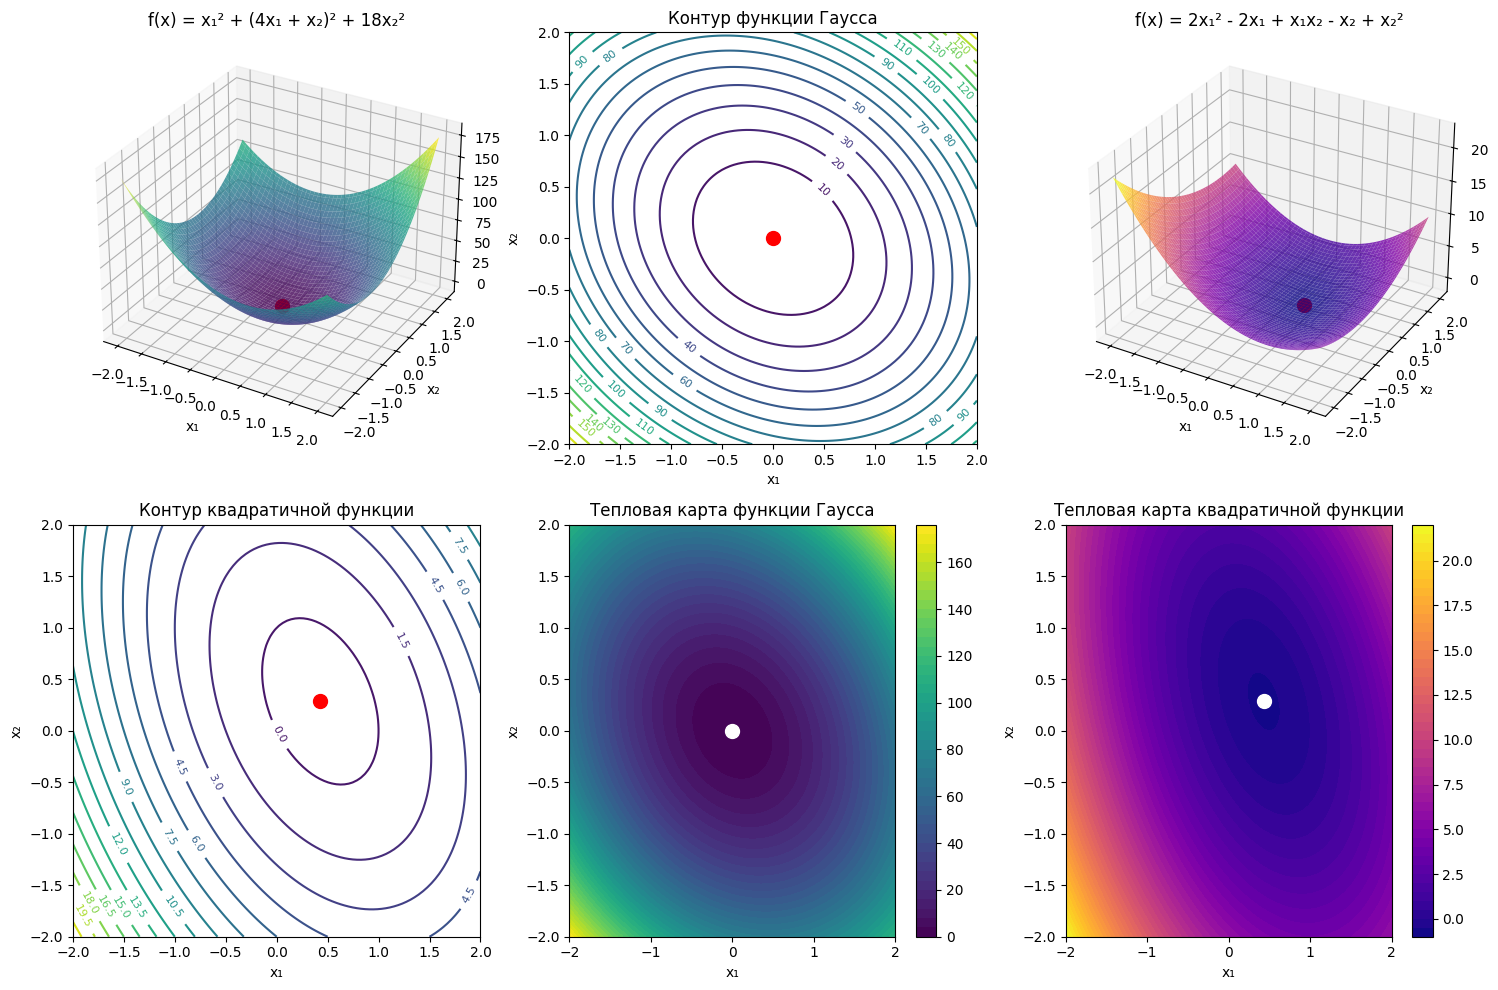


Запуск экспериментов методом наискорейшего градиентного спуска...

Запуск экспериментов методом Флетчера-Ривса...

Запуск экспериментов методом Гаусса-Зейделя...

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ

Статистика для функции f_gauss:
                 error                     evaluations                   \
                   min       max      mean         min  max        mean   
method                                                                    
fletcher_reeves    0.0  0.014085  0.001879           2    5    3.466667   
gauss_seidel       0.0  0.000052  0.000011          34  432  188.266667   
gradient_descent   0.0  0.011063  0.001492           1    5    3.133333   

                 iterations                
                        min max      mean  
method                                     
fletcher_reeves           0   3  1.466667  
gauss_seidel              1   6  3.400000  
gradient_descent          0   5  2.800000  

Статистика для функции f_quadratic:
                 error 

/tmp/ipykernel_134508/281347705.py:174: RuntimeWarning: invalid value encountered in scalar divide
  beta = np.dot(g_new, g_new) / np.dot(g_current, g_current)


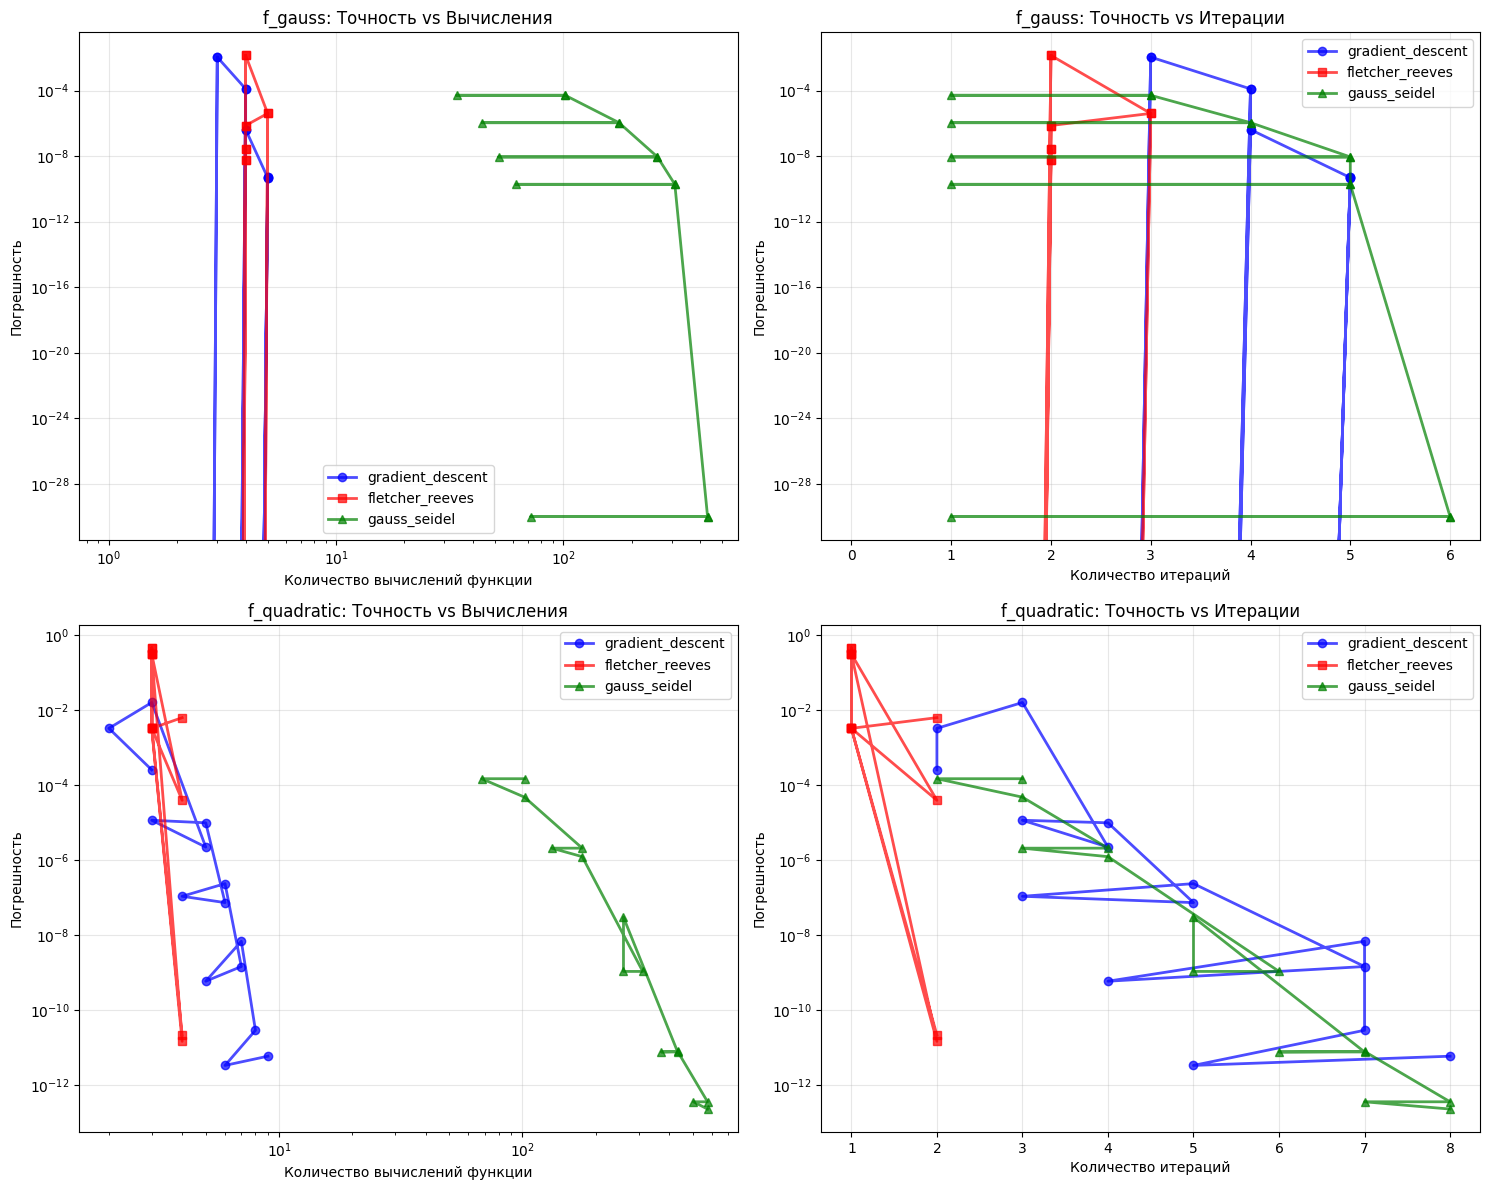

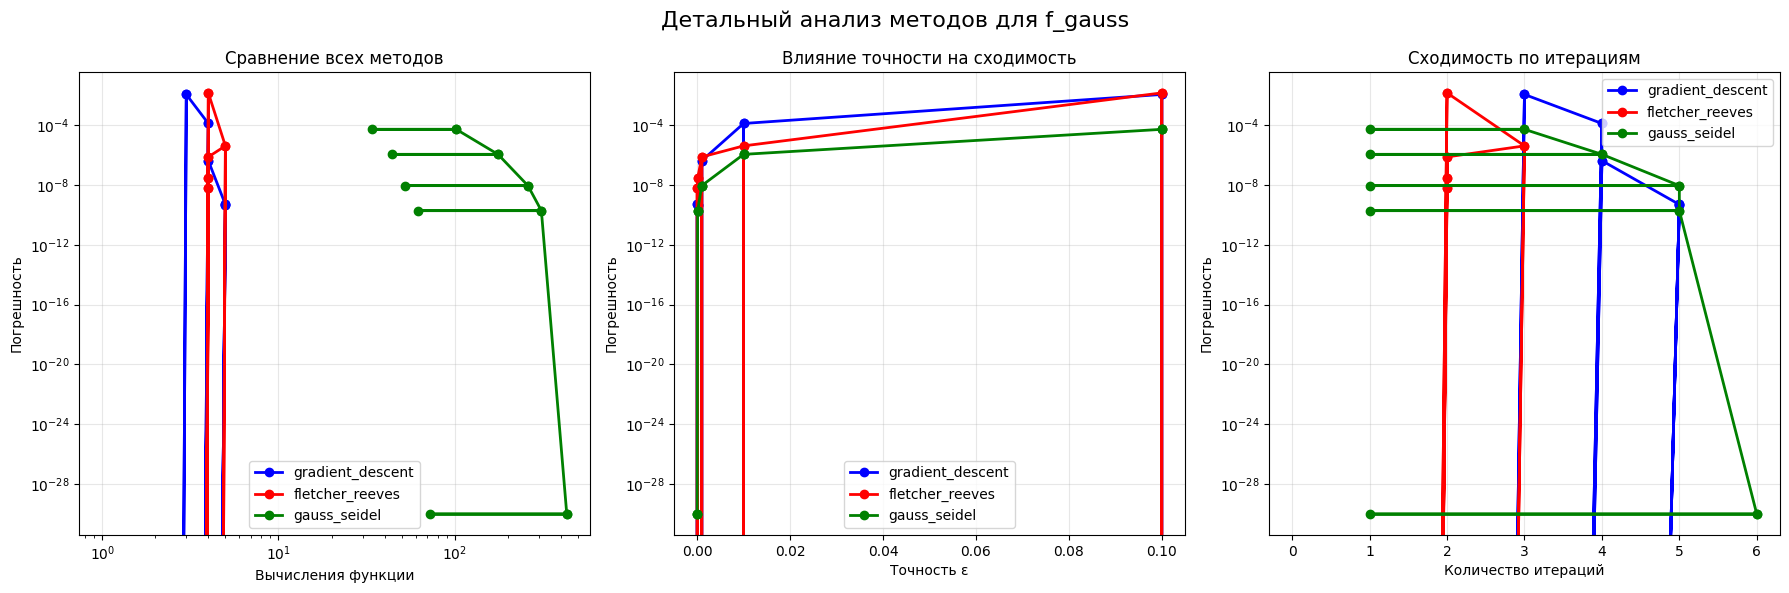

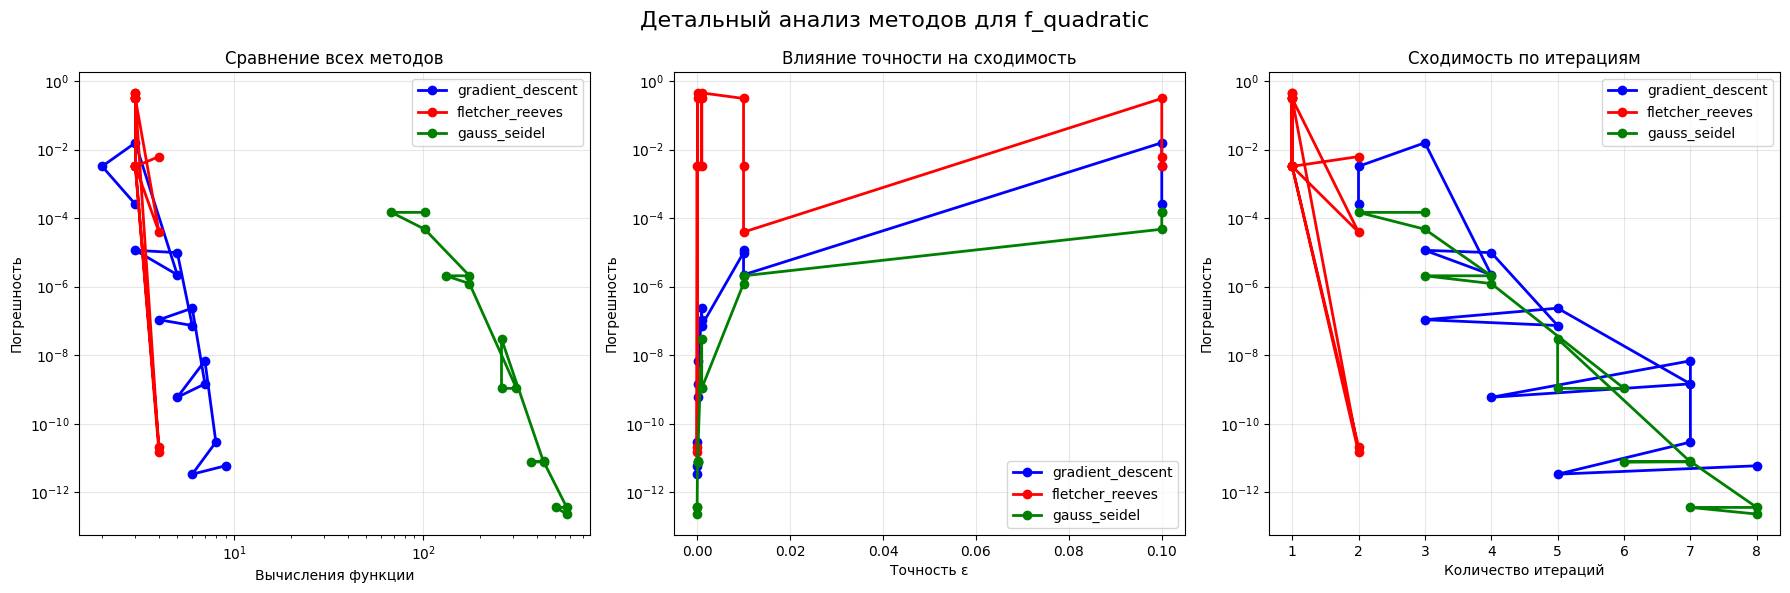


РЕКОМЕНДАЦИИ ПО ВЫБОРУ МЕТОДА
Для квадратичных функций:
1. Метод Флетчера-Ривса - наиболее эффективен (теоретически сходится за n итераций)
2. Метод наискорейшего спуска - хорошая сходимость, прост в реализации
3. Метод Гаусса-Зейделя - надежный, но может быть медленнее для плохо обусловленных задач

Оптимальные параметры:
- Точность ε=1e-4 обеспечивает хороший баланс точности и скорости
- Начальные точки не сильно влияют на сходимость для выпуклых функций


In [20]:
# Параметры экспериментов
EPS_VALUES = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]  # для всех методов

# Начальные точки для методов
INITIAL_POINTS = [
    np.array([-2., -2.]), 
    np.array([0., 0.]), 
    np.array([2., 2.])
]

# Создание и настройка эксперимента
experiment = OptimizationExperiment()

# Вычисление эталонных минимумов
references = experiment.compute_reference_minima()

# Анализ функций
experiment.plot_function_analysis()


# Проведение экспериментов
experiment.run_gradient_descent_experiments(EPS_VALUES, INITIAL_POINTS)
experiment.run_fletcher_reeves_experiments(EPS_VALUES, INITIAL_POINTS)
experiment.run_gauss_seidel_experiments(EPS_VALUES, INITIAL_POINTS)

# Анализ результатов
results_df = experiment.create_results_dataframe()

# Вывод сводной таблицы
print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*80)

# Статистика по методам для обеих функций
for func_name in ['f_gauss', 'f_quadratic']:
    print(f"\nСтатистика для функции {func_name}:")
    func_stats = results_df[results_df['function'] == func_name].groupby('method').agg({
        'error': ['min', 'max', 'mean'],
        'evaluations': ['min', 'max', 'mean'],
        'iterations': ['min', 'max', 'mean']
    }).round(6)
    print(func_stats)

# Лучшие результаты для каждого метода
print("\nЛучшие результаты для каждой функции:")
for func_name in ['f_gauss', 'f_quadratic']:
    print(f"\n{func_name}:")
    func_results = results_df[results_df['function'] == func_name]
    best_results = func_results.loc[func_results.groupby('method')['error'].idxmin()]
    
    display_cols = ['method', 'parameter', 'evaluations', 'iterations', 
                    'error', 'f_min']
    
    print(best_results[display_cols].round(6))

# Построение графиков
print("\nПостроение графиков сравнения...")
experiment.plot_comparison_all_methods(results_df)
experiment.plot_detailed_analysis(results_df)

# Вывод рекомендаций
print("\n" + "="*80)
print("РЕКОМЕНДАЦИИ ПО ВЫБОРУ МЕТОДА")
print("="*80)
print("Для квадратичных функций:")
print("1. Метод Флетчера-Ривса - наиболее эффективен (теоретически сходится за n итераций)")
print("2. Метод наискорейшего спуска - хорошая сходимость, прост в реализации")
print("3. Метод Гаусса-Зейделя - надежный, но может быть медленнее для плохо обусловленных задач")
print("\nОптимальные параметры:")
print("- Точность ε=1e-4 обеспечивает хороший баланс точности и скорости")
print("- Начальные точки не сильно влияют на сходимость для выпуклых функций")
